In [1]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
import fastf1
from scipy.optimize import curve_fit
fastf1.Cache.enable_cache('./f1cache')
from dataclasses import dataclass, field
import enum

In [2]:
class Tyre(enum.Enum):
    MEDIUM = "MEDIUM"
    HARD = "HARD"
    SOFT = "SOFT"
    INTERMEDIATE = "INTERMEDIATE"
    WET = "WET"

In [3]:
session = fastf1.get_session(2022, 'Djeddah', 'R')
session.load(telemetry=True, laps=True, weather=True)
laps = session.laps
laps.head(0)

session     WARNING 	Request for URL https://raw.githubusercontent.com/theOehrly/f1schedule/master/schedule_2022.json failed; using cached response
Traceback (most recent call last):
  File "/Users/jroga/Documents/f1 stats/f1thon/lib/python3.9/site-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/Users/jroga/Documents/f1 stats/f1thon/lib/python3.9/site-packages/urllib3/util/connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/usr/local/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jroga/Documents/f1 stats/f1thon/lib/pyt

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate


In [4]:
tyreColor = {
    "MEDIUM": "yellow",
    "HARD": "black",
    "SOFT": "red",
    "INTERMEDIATE": "green",
    "WET": "blue"
}
laps["LapTime_s"] = laps["LapTime"].dt.total_seconds()
amount_laps = int(laps["LapNumber"].max())

In [5]:
def plotter(title, xlabel, ylabel):
    plt.figure(figsize=(15,5))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [6]:
# Working on laps to remove any pitstop/safety car/begin 
laps_clean = laps.loc[(laps["PitOutTime"].isna() & laps["PitInTime"].isna()) & (laps["TrackStatus"].astype(int) == 1)].reset_index(drop=True)

In [7]:
# Find pit time
laps_pitstop = laps.loc[(~laps["PitOutTime"].isna()) | (~laps["PitInTime"].isna())].loc[:, ["Driver", "Compound", "LapNumber", "PitInTime", "PitOutTime"]]
laps_pitstop["PitInTime_shifted"] = laps_pitstop.groupby("Driver")["PitInTime"].shift(1)
laps_pitstop["PitStopTime"] = (laps_pitstop["PitOutTime"] - laps_pitstop["PitInTime_shifted"]).dt.total_seconds()
laps_pitstop.loc[laps_pitstop["LapNumber"] == 1, "PitStopTime"] = 0
laps_pitstop = laps_pitstop.loc[laps_pitstop["PitStopTime"].notna(), ["Driver", "Compound", "LapNumber", "PitStopTime"]].reset_index(drop=True)
laps_pitstop.query("Driver == 'LEC'")

,Driver,Compound,LapNumber,PitStopTime
2,LEC,MEDIUM,1.0,0.000
3,LEC,HARD,17.0,21.024


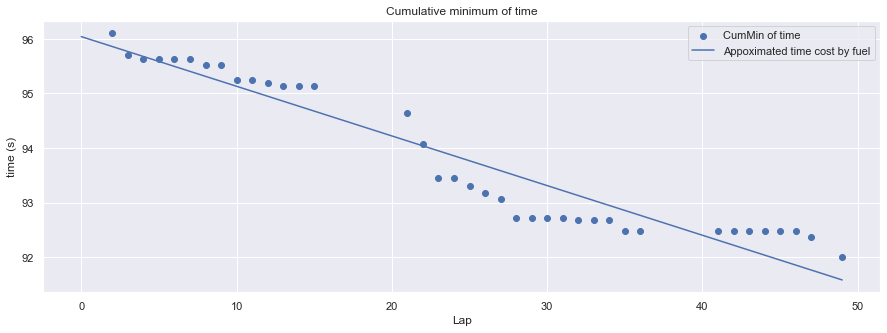

In [8]:
# Applying fuel penalty to lap time.

def P1(x, a, b):
        return a - abs(b)*x
p0 = [80, 1] # this is an mandatory initial guess

comp_min = laps_clean.groupby(["LapNumber", "Compound"])["LapTime_s"].min().reset_index().groupby("LapNumber").mean().cummin()
opt_lapTime, _ = curve_fit(P1, comp_min.dropna().index, comp_min.dropna()["LapTime_s"], p0)
fuel_time = pd.Series(index=np.arange(amount_laps), data=P1(np.arange(amount_laps), *opt_lapTime), name="LapTime")
fuel_time_pen = fuel_time - fuel_time.min()
laps["LapTime_s_fuel"] = (laps["LapTime_s"] - fuel_time_pen.values[laps["LapNumber"].astype(int).values - 1])

plotter("Cumulative minimum of time", "Lap", "time (s)")
plt.scatter(comp_min.index, comp_min, label="CumMin of time")
plt.plot(fuel_time, label="Appoximated time cost by fuel")
plt.legend()
plt.show()

/Users/jroga/Documents/f1 stats/f1thon/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/jroga/Documents/f1 stats/f1thon/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


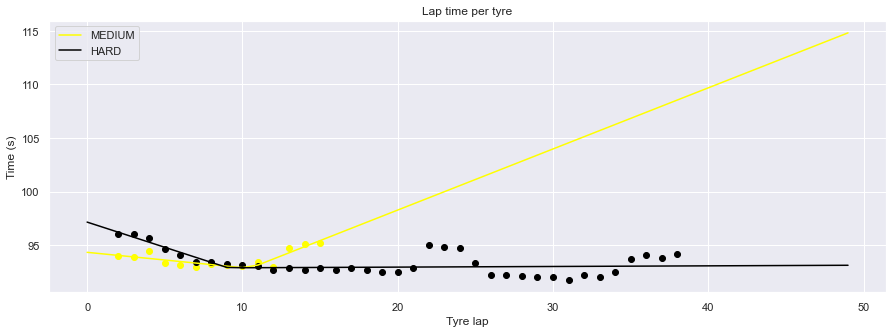

In [21]:
# Applying tyre penalty to lap time.

def PX(x, a, b, c, d, x0, x1, x2):
        return a - abs(b)*np.maximum(x0, x) + abs(c)*np.maximum(x1, x) # + abs(np.maximum(d, 1))*np.maximum(x2, x)
p0_X = [80, 1, 1, 1, 5, 10, 50] # this is an mandatory initial guess

def P1(x, a, b):
        return a - abs(b)*x
p0_1 = [80, 1] # this is an mandatory initial guess

tyreWear = {}

plotter("Lap time per tyre", "Tyre lap", "Time (s)")
for tyreCompound in tyreColor:
    comp = laps_clean.query(f"Compound == '{tyreCompound}'").reset_index()
    if len(comp):
        comp_min = comp.groupby("TyreLife")["LapTime_s"].min()
        filtered_time = comp_min
        try:
            opt_lapTime, _ = curve_fit(PX, filtered_time.dropna().index, filtered_time.dropna(), p0_X, maxfev = 80000)
            tyreWear[tyreCompound] = PX(np.arange(amount_laps), *opt_lapTime)
        except TypeError:
            print("Error for compound " + tyreCompound)
            opt_lapTime, _ = curve_fit(P1, filtered_time.dropna().index, filtered_time.dropna(), p0_1, maxfev = 80000)
            tyreWear[tyreCompound] = P1(np.arange(amount_laps), *opt_lapTime)
            
        plt.scatter(
            filtered_time.index,
            filtered_time,
            color=tyreColor[tyreCompound]
        )
        plt.plot(
            tyreWear[tyreCompound],
            label=tyreCompound,
            color=tyreColor[tyreCompound]
        )
plt.legend()
plt.show()

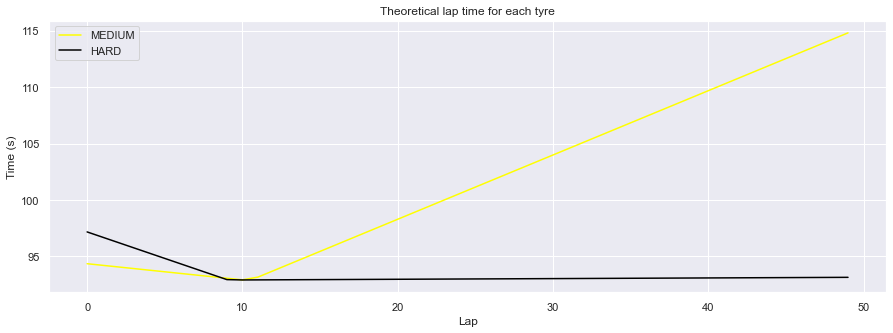

In [22]:
plotter("Theoretical lap time for each tyre", "Lap", "Time (s)")
for compound in tyreWear:
    plt.plot(tyreWear[compound], label=compound, color=tyreColor[compound])
plt.legend()
plt.show()

In [23]:
@dataclass
class PitStop():
    new_tyre: Tyre
    lap: int
    pit_rolling: float = field(default=17)
    pit_time: float = field(default=2.5)

strategy_leclerc_reel = [
    PitStop(Tyre.MEDIUM, 0, 25, 0),
    PitStop(Tyre.MEDIUM, 22),
    PitStop(Tyre.HARD, 40),
    PitStop(Tyre.SOFT, 55),
    PitStop(Tyre.SOFT, 80)
]

strategy_leclerc_opti = [
    PitStop(Tyre.MEDIUM, 0, 25, 0),
    PitStop(Tyre.MEDIUM, 20, 25, 0),
    PitStop(Tyre.SOFT, 53),
    PitStop(Tyre.SOFT, 80)
]

In [24]:
stop = 0
times = []

cur_compound = None
cur_compound_lap = None

strategy = strategy_leclerc_opti
for lap in range(amount_laps):
    lap_time = 0
    if strategy[stop].lap == lap:
        # Add PitStop
        lap_time += strategy[stop].pit_rolling + strategy[stop].pit_time
        cur_compound = strategy[stop].new_tyre
        cur_compound_lap = 0
        stop += 1
    fuel_time = fuel_time_pen[lap]
    tyre_time = tyreWear[cur_compound.value][cur_compound_lap]
    lap_time += fuel_time + tyre_time
    times.append(lap_time)
    cur_compound_lap += 1

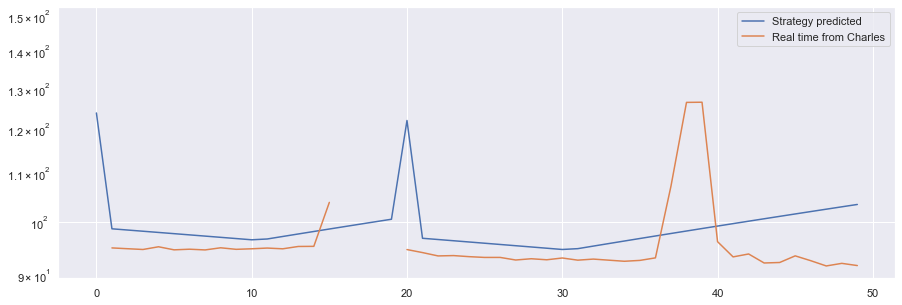

In [26]:
plt.figure(figsize=(15,5))
plt.semilogy(times, label="Strategy predicted")
plt.semilogy(laps.query("Driver == 'LEC'").set_index("LapNumber")["LapTime_s"].values, label="Real time from Charles")
plt.legend()
plt.show()

In [570]:
plt.plot(pd.Series(times[0:55]).cumsum()-laps.query("Driver == 'LEC'").set_index("LapNumber")["LapTime_s"].dropna().cumsum().values[:55], label="Real time from Charles")

KeyError: 'LapTime_s'

In [522]:
laps.query("Driver == 'LEC'").set_index("LapNumber")["LapTime_s"].cumsum().dropna()[:55]

LapNumber
2      144.979
3      248.197
4      350.082
5      449.761
6      547.807
7      644.988
8      742.414
9      839.002
10     935.301
11    1030.624
12    1125.701
13    1219.366
14    1312.680
15    1404.778
16    1496.911
17    1588.401
18    1699.249
19    1789.398
20    1877.554
21    1984.114
22    2076.703
23    2165.482
24    2249.641
25    2332.777
26    2415.505
27    2537.981
28    2664.922
29    2782.668
32    2903.368
33    2986.691
34    3068.360
35    3147.472
36    3226.866
37    3305.627
38    3383.170
39    3460.150
40    3537.597
41    3614.458
42    3691.445
43    3768.451
44    3845.370
45    3921.849
46    3998.098
47    4074.590
48    4151.486
49    4227.975
50    4305.497
51    4382.270
52    4459.081
53    4536.216
54    4613.925
55    4691.865
56    4770.487
57    4849.547
58    4928.499
dtype: float64

In [449]:
pd.Series(times[0:55]).cumsum()

0      109.010320
1      192.998924
2      276.965811
3      360.910981
4      444.834434
5      528.736171
6      612.616190
7      696.474493
8      780.311079
9      864.125948
10     947.919101
11    1031.690537
12    1115.440256
13    1199.168258
14    1282.874543
15    1366.538344
16    1450.159659
17    1533.738489
18    1617.274835
19    1700.768695
20    1784.220070
21    1867.628960
22    1976.161511
23    2059.672346
24    2143.161463
25    2226.628864
26    2310.074548
27    2393.498515
28    2476.900765
29    2560.281299
30    2643.640115
31    2726.977215
32    2810.292598
33    2893.586265
34    2976.858214
35    3060.108447
36    3143.336963
37    3226.522994
38    3309.666540
39    3392.767601
40    3475.826177
41    3558.842268
42    3641.815874
43    3724.746995
44    3807.635631
45    3890.544993
46    3973.563652
47    4056.691607
48    4139.928860
49    4223.275410
50    4306.731257
51    4390.296401
52    4473.970841
53    4557.754579
54    4641.647613
dtype: flo